#  <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

## Homework 7: Classification with Logistic Regression, LDA/QDA, and Trees


**Harvard University**<br/>
**Fall 2018**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader

<hr style="height:2pt">



In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the [instructions given in Canvas](https://canvas.harvard.edu/courses/42693/pages/homework-policies-and-submission-instructions).

- If needed, clarifications will be posted on Piazza.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below. 


**Name of the person you have worked with goes here:**
<br><BR>

<hr style="height:2pt">

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['b', 'r', 'm','g'])

<div class='exercise'><b> Question 1 [20 pts]: Overview of Multiclass Thyroid Classification </b></div>

In this problem set you will build a model for diagnosing disorders in a patient's thyroid gland. Given the results of medical tests on a patient, the task is to classify the patient either as:
- *normal* (class 1)
- having *hyperthyroidism* (class 2)
- or having *hypothyroidism* (class 3). 

The data set is provided in the file `dataset_hw7.csv`. Columns 1-2 contain biomarkers for a patient (predictors):
- Biomarker 1: (Logarithm of) level of basal thyroid-stimulating hormone (TSH) as measured by radioimmuno assay
- Biomarker 2: (Logarithm of) maximal absolute difference of TSH value after injection of 200 micro grams of thyrotropin-releasing hormone as compared to the basal value.

The last column contains the diagnosis for the patient from a medical expert. This data set was [obtained from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/Thyroid+Disease); for this assignment we chose two predictors so we can visualize the decision boundaries.

Notice that unlike previous exercises, the task at hand is a 3-class classification problem. We will explore different methods for multiclass classification.

For most of this problem set, we'll measure overall classification accuracy as the fraction of observations classified correctly.

**1.1** Load the data and examine its structure. How many instances of each class are there in our dataset? In particular, what is the ratio of the number of observations in class 2 (hyperthyroidism) to the number of observations in class 3 (hypothyroidism)? We'll refer to this as the *hyper-to-hypo ratio*.

In [4]:
# read in data and print summary statistics
bio_df = pd.read_csv("dataset_hw7.csv")
bio_df.describe()

,Biomarker 1,Biomarker 2,Diagnosis
count,215.000000,215.000000,215.000000
mean,0.414441,0.303155,1.441860
std,0.888106,2.174369,0.726737
min,-2.302485,-11.512925,1.000000
25%,0.000010,-0.510809,1.000000
50%,0.262372,0.693152,1.000000
75%,0.530634,1.410989,2.000000
max,4.032469,4.030695,3.000000


In [5]:
bio_df.dtypes

Biomarker 1    float64
Biomarker 2    float64
Diagnosis        int64
dtype: object

In [152]:
# renaming Biomarker columns for simplicity
bio_df.columns = ["bio1","bio2","diagnosis"]

In [90]:
num_dx = bio_df.groupby("diagnosis").apply(lambda x: x.shape[0])
ratio = num_dx[3]/num_dx[2]
print("hyper-to-hypo ratio: {0:.2f} to {1:.2f}".format(1,ratio))

hyper-to-hypo ratio: 1.00 to 0.86


**1.2**: We're going to split this data into a 50% training set and a 50% test set. But since our dataset is small, we need to make sure we do it correctly. Let's see what happens when we *don't* split correctly: for each of 100 different random splits of the data into 50% train and 50% test, compute the hyper-to-hypo for the observations end up in the training set. Plot the distribution of the hyper-to-hypo ratio; on your plot, also mark the hyper-to-hypo ratio that you found in the full dataset. Discuss how representative the training and test sets are likely to be if we were to have selected one of these random splits.

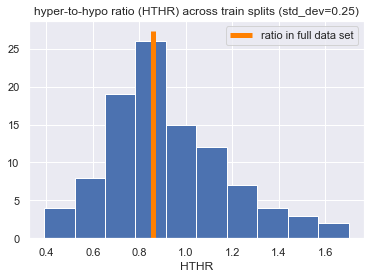

In [91]:
# split data 100 times and calculate hyper to hypo ratio
n_splits = 100
ratios = np.empty(n_splits, dtype=float)
for i in range(n_splits):
    train_df, test_df = train_test_split(bio_df, test_size=.5)
    num_dx = train_df.groupby("diagnosis").apply(lambda x: x.shape[0])
    ratios[i] = num_dx[3]/num_dx[2]

plt.hist(ratios, color='b')
ax=plt.gca()
ax.vlines(ratio,ax.get_ylim()[0],ax.get_ylim()[1], color=(1,.5,0), lw=5, label="ratio in full data set")
ax.set_xlabel("HTHR")
ax.set_title("hyper-to-hypo ratio (HTHR) across train splits (std_dev={0:.2f})".format(np.std(ratios)))
ax.legend();

We can see that the randomly sampled HTHR spans a range of 0.4-1.6 with a standard deviation of 0.25. If we don't stratify by `Diagnosis` it's likely that we could to see a train/test difference in HTHR of 0.5 or greater. 

**1.3** Now, we'll use the `stratify` option to split the data in such a way that the relative class frequencies are preserved (the code is provided). Make a table showing how many observations of each class ended up in your training and test sets. Verify that the hyper-hypo ratio is roughly the same in both sets.

In [92]:
data_train, data_test = train_test_split(bio_df, test_size=.5, stratify=bio_df.diagnosis, random_state=99);

In [93]:
# calculate ratio in each data set
train_num_dx = data_train.groupby("diagnosis").apply(lambda x: x.shape[0])
train_ratio = train_num_dx[3]/train_num_dx[2]
test_num_dx = data_test.groupby("diagnosis").apply(lambda x: x.shape[0])
test_ratio = test_num_dx[3]/test_num_dx[2]
df_ratios = pd.concat((train_num_dx,test_num_dx), axis=1)
df_ratios.loc["ratio"] = (train_ratio,test_ratio)
df_ratios.columns = ["train","test"]
df_ratios

,train,test
diagnosis,,
1,75.000000,75.000000
2,17.000000,18.000000
3,15.000000,15.000000
ratio,0.882353,0.833333


**1.4** Provide the scatterplot of the predictors in the (training) data in a way that clearly indicates which class each observation belongs to.

In [244]:
c = bio_df.diagnosis.values

array([1, 2, 3], dtype=int64)

In [258]:
# define function to scatter classes
def scatter_class(x,y,c):
    
    classes = np.unique(c)
    colors = ((0,0,.8),(.8,.4,0),(0,.6,0))
    
    for i,clas in enumerate(classes):
        mask = c==clas
        plt.scatter(x[mask], y[mask], color=colors[i], s=30, edgecolor='w', label=clas)
    ax = plt.gca() 
    ax.set_xlabel("Biomarker 1")
    ax.set_ylabel("Biomarker 2")
    ax.legend(loc="lower right")
    
    return(ax)

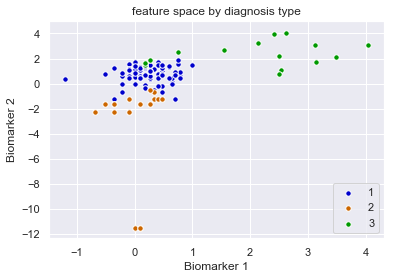

In [259]:
# plot data colored by diagnosis type
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("feature space by diagnosis type");

**1.5**: When we first start working with a dataset or algorithm, it's typically a good idea to figure out what *baselines* we might compare our results to. For regression, we always compared against a baseline of predicting the mean (in computing $R^2$). For classification, a simple baseline is always predicting the *most common class*. What "baseline" accuracy can we achieve on the thyroid classification problem by always predicting the most common class? Assign the result to `baseline_accuracy` so we can use it later. (**note: don't look at the test set until instructed**)

In [161]:
# compute and print prevalance of normal (most common class)
baseline_accuracy = np.sum(data_train.diagnosis==1)/data_train.shape[0]
print("baseline accuracy = {0:.2f}".format(baseline_accuracy))

baseline accuracy = 0.70


**1.6** Make a decision function to separate these samples using no library functions; just write out your logic by hand. Your manual classifier doesn't need to be well-tuned (we'll be exploring algorithms to do that!); it only needs to (1) predict each class at least once, and (2) achieve an accuracy at least 10% greater accurate than predicting the most likely class. Use the `overlay_decision_boundaries` function provided above to overlay the decision boundaries of your function on the training set. (Note that the function modifies an existing plot, so call it after plotting your points.)

Based on your exploration, do you think a linear classifier (i.e., a classifier where all decision boundaries are line segments) could achieve above 85% accuracy on this dataset? Could a non-linear classifier do better? What characteristics of the data lead you to these conclusions?

In [188]:
def overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.5):
    """
    A function that visualizes the decision boundaries of a classifier.
    
    ax: Matplotlib Axes to plot on
    model: Classifier (has a `.predict` method)
    X: feature vectors
    y: ground-truth classes
    colors: list of colors to use. Use color colors[i] for class i.
    nx, ny: number of mesh points to evaluated the classifier on
    desaturate: how much to desaturate each of the colors (for better contrast with the sample points)
    """
    # Create mesh
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    xx, yy = np.meshgrid(
        np.linspace(xmin, xmax, nx),
        np.linspace(ymin, ymax, ny))
    X = np.c_[xx.flatten(), yy.flatten()]

    # Predict on mesh of points
    if hasattr(model, 'predict'):
        model = model.predict
    y = model(X)
    y = y.reshape((nx, ny))

    # Generate colormap.
    if colors is None:
        colors = sns.utils.get_color_cycle()
        y -= y.min() # If first class is not 0, shift.
    assert np.max(y) <= len(colors)
    colors = [sns.utils.desaturate(color, desaturate) for color in colors]
    cmap = matplotlib.colors.ListedColormap(colors)

    # Plot decision surface
    ax.pcolormesh(xx, yy, y, zorder=-2, cmap=cmap, norm=matplotlib.colors.NoNorm(), vmin=0, vmax=y.max() + 1)
    xx = xx.reshape(nx, ny)
    yy = yy.reshape(nx, ny)
#     ax.contourf(xx, yy, y, cmap=cmap, vmin=0, vmax=3)
    ax.contour(xx, yy, y, colors="black", linewidths=1, zorder=-1)

In [298]:
# define predictors/response
X = data_train[["bio1","bio2"]].values
y = data_train.diagnosis.values

In [165]:
# manually predicts class assignment for a single sample
def predict_manual_one_sample(x):
    """"
    Input:
        x - a (1x2) array of (bio1,bio2) for a single data point
    Output:
        c - diagnostic class prediction for x

    """
    
    # manually define feature boundaries
    if x[0] > 1:
        c = 3
    elif x[1] > -.2:
        c = 1
    else:
        c = 2
    
    return(c)

In [170]:
# predict input array
def predict_manual(X):
    return np.array([predict_manual_one_sample(x) for x in X])


In [168]:
manual_predictions = predict_manual(X)
accuracy = accuracy_score(y, manual_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.8691588785046729


In [169]:
assert accuracy >= (baseline_accuracy * 1.10), "Accuracy too low"
assert all(np.sum(manual_predictions == i) > 0 for i in [1, 2, 3]), "Should predict each class at least once."

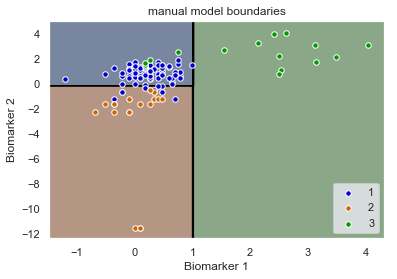

In [279]:
# plot data colored by diagnosis type
# ax = scatter_class(X[:,0],X[:,1],manual_predictions)
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("manual model boundaries")
overlay_decision_boundary(ax, predict_manual, colors=None, nx=200, ny=200, desaturate=.3)

Considering that this model has an 87% accuracy, it's hard to imagine that a linear classifier could reach 85%. We had to draw 2 perpendicular lines to reach this accuracy; so it seems like a single line will not separate the classes well.

<div class='exercise'><b> Question 2 [20 pts]: Multiclass Logistic Regression</b></div>

**2.1** Fit two one-vs-rest logistic regression models using sklearn. For the first model, use the train dataset as-is (so the decision boundaries will be linear); for the second model, also include quadratic and interaction terms. For both models, use $L_2$ regularization, tuning the regularization parameter using 5-fold cross-validation. 

For each model, make a plot of the training data with the decision boundaries overlayed.

*Hint*: You should use `LogisticRegressionCV`. For the model with quadratic and interaction terms, use the following Pipeline:

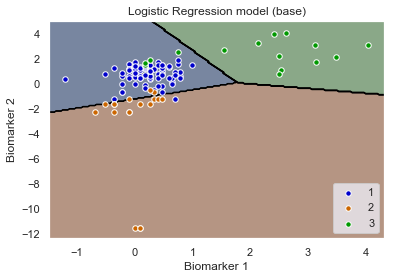

In [278]:
# fit and plot base model with no added terms
logit_base = LogisticRegressionCV(solver='newton-cg', cv=5, max_iter=1000, multi_class='ovr').fit(X,y)
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("Logistic Regression model boundaries (base)")
overlay_decision_boundary(ax, logit_base, colors=None, nx=200, ny=200, desaturate=.3)

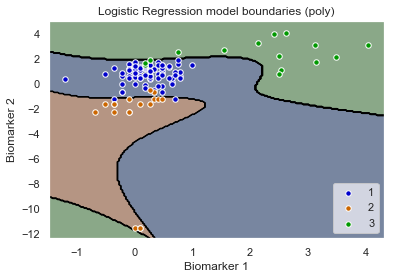

In [309]:
# define and fit model with quadratic and interaction terms
logit_poly = make_pipeline(
    PolynomialFeatures(degree=4, include_bias=False),
    LogisticRegressionCV(solver='newton-cg', cv=5, max_iter=1000, multi_class='ovr'))
logit_poly = polynomial_logreg_estimator.fit(X,y)

# Note that you can access the logistic regression classifier itself by
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("Logistic Regression model boundaries (poly)")
overlay_decision_boundary(ax, logit_poly, colors=None, nx=200, ny=200, desaturate=.3)

**2.2** Interpret the decision boundaries:
- *Do these decision boundaries make sense?*<br><br>
    -Yes, these boundaries make sense. They both look reasonably fit to the data. The linear logistic model has a straight line defining the boundary between any two categories and the quadratic logistic regression model is defining the boundary with curved lines.<br><br>
- What does adding quadratic and interaction features do to the shape of the decision boundaries? Why?<br><br>
    -Adding these features changes the decision boundaries from straight lines to polynomials. The shape of the decision boundary is fit by minimizing our loss function over higher order features. The shape of these boundaries means that we achieve a lower loss by drawing non-straight boundaries. <br><br>
- How do the different models treat regions where there are few samples? How do they classify such samples?<br><br>
    -The boundaries in sparsely population regions of the space have been fit so as to improve the misclassification rate. If we look at the lower right region of the plot where there are no values, it's clear that the classification of these areas has been just kind of been a by-product of whatever lines result in the best accuracy in the populated areas. The lower left of the quadratic plot shows the decision boundary is clearly overfit to the two hyperthyroidism points.

**2.3** Compare the performance of the two logistic regression models above using 5-fold cross-validation. Which model performs best? How confident are you about this conclusion? Does the inclusion of the polynomial terms in logistic regression yield better accuracy compared to the model with only linear terms? Why do you suspect it is better or worse?

*Hint*: You may use the `cross_val_score` function for cross-validation.

In [307]:
# report avg cross validation accuracy on training data
print("mean accuracy (logit_base): {0:.3f}".format(cross_val_score(logit_base, X, y, cv=5).mean()))
print("mean accuracy (logit_poly): {0:.3f}".format(cross_val_score(logit_poly, X, y, cv=5).mean()))

mean accuracy (logit_base): 0.917
mean accuracy (logit_poly): 0.898


The base (linear) logistic regression model performs slightly better. We can't be too confident because we're still only reporting accuracy on the training data (just splitting it up multiple times). That being said, if the base model is outperforming on the training data, then it's likely to outperform on the test data as well. In general if we expect a model to perform better on train than test, it's due to overfitting. Of the two models, we would expect the model with quadratic terms to be more overfit. The inclusion of polynomial terms is already producing a lower average accuracy when cross-validating with the test data, most likely because the model is overfit.

<div class='exercise'><b> Question 3 [20 pts]: Discriminant Analysis</b></div>

**3.1** Consider the following synthetic dataset with two classes. A green star marks a test observation; which class do you think it belongs to? How would LDA classify that observation? How would QDA? Explain your reasoning.

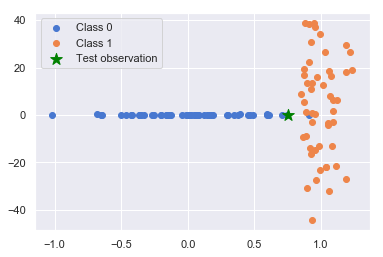

In [312]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

LDA will likely classify the point as orange, because LDA assumes that the covariance matrices of each class are the same. Even though it looks more like a blue, LDA will probably assume the variation along the x-axis is somewhere between the x-variation for class 0 and class 1, which will probably put it in class 1. We can check with the boundary decision function.

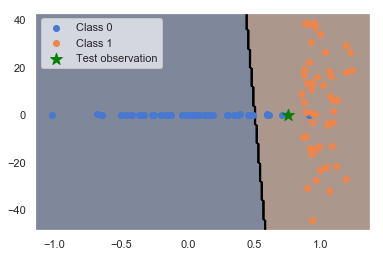

In [316]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

lda = LinearDiscriminantAnalysis().fit(X_blobs,y_blobs)
overlay_decision_boundary(plt.gca(), lda, colors=None, nx=200, ny=200, desaturate=.2)

QDA will likely classify the point as blue, because we do not have to assume equal covariance. The test observation falls within the observed range of class 0, but not class 1. Again, we can plot the decision boundary to check.

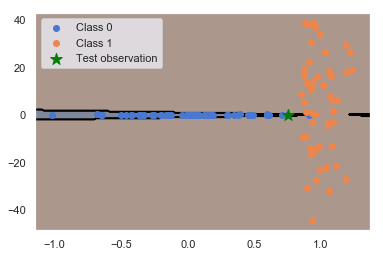

In [319]:
X_blobs, y_blobs = make_blobs(centers=[[0., 0.], [1., 0.]], cluster_std=[[.4, .1], [.1, 20.]], random_state=0)
plt.scatter(X_blobs[y_blobs==0][:,0], X_blobs[y_blobs==0][:,1], label="Class 0")
plt.scatter(X_blobs[y_blobs==1][:,0], X_blobs[y_blobs==1][:,1], label="Class 1")
plt.scatter([.75], [0.], color="green", marker="*", s=150, label="Test observation")
plt.legend();

qda = QuadraticDiscriminantAnalysis().fit(X_blobs,y_blobs)
overlay_decision_boundary(plt.gca(), qda, colors=None, nx=200, ny=200, desaturate=.2)

**3.2** Now let's return to the thyroid dataset. Make a table of the total variance of each class for each biomarker.

In [329]:
variance_by_dx = bio_df.groupby("diagnosis")[["bio1","bio2"]].apply(np.var)
variance_by_dx

,bio1,bio2
diagnosis,,
1,0.150133,1.919572
2,0.299781,7.967889
3,1.055730,0.871698


**3.3** Fit LDA and QDA on the thyroid data, and plot the decision boundaries. Comment on how the decision boundaries differ. How does the difference in decision boundaries relate to characteristics of the data, such as the table you computed above?

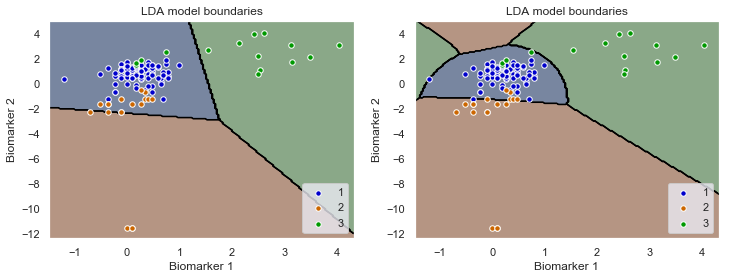

In [326]:
# fit LDA model to training data and plot
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
lda = LinearDiscriminantAnalysis().fit(X,y)
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("LDA model boundaries")
overlay_decision_boundary(ax, lda, colors=None, nx=200, ny=200, desaturate=.3)

# fit QDA model to training data and plot
plt.subplot(1,2,2)
qda = QuadraticDiscriminantAnalysis().fit(X,y)
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("LDA model boundaries")
overlay_decision_boundary(ax, qda, colors=None, nx=200, ny=200, desaturate=.3)

We can see from the variance table that the `class 2` has much larger variance in `Biomarker 2` than either of the other classes. The assumption of equal variance in LDA is not a good one. The major failing of the LDA model is that appears to draw the boundary too low between `class 2` and `class 1`, which corresponds to the `class 1` gaussian being too broad along the `Biomarker 2` dimension. QDA does not make this assumption and consequently draws a more accurate boundary. The island of blue in QDA reflects the fact that `class 1` has a lower variance than either of the other two classes for both biomarker dimensions. Blue peaks up above the other two, but the gaussian is so narrow along both dimensions that it falls below the other 2 in the tails.

<div class='exercise'> <b> Question 4 [20 pts]: Fit Decision Trees </b> </div> 


We next try out decision trees for thyroid classification. For the following questions, you should use the *Gini* index as the splitting criterion while fitting the decision tree. 

*Hint:* You should use the `DecisionTreeClassifier` class to fit a decision tree classifier and the `max_depth` attribute to set the tree depth.

**4.1**. Fit a decision tree model to the thyroid data set with (maximum) tree depths 2, 3, ..., 10. Make plots of the accuracy as a function of the maximum tree depth, on the training set and the mean score on the validation sets for 5-fold CV. Is there a depth at which the fitted decision tree model achieves near-perfect classification on the training set? If so, what can you say about how this tree will generalize? Which hyperparameter setting gives the best cross-validation performance?

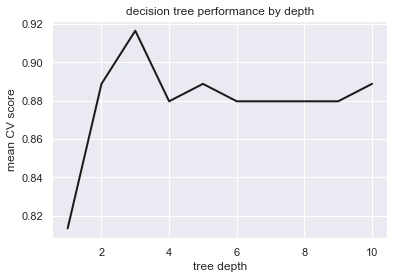

In [341]:
# define depths to test
depths = np.arange(1,11,1)
avg_score = np.empty(depths.shape, dtype=float)

# fit decision tree at each depth and record accuracy
for i, depth in enumerate(depths):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth).fit(X,y)
    avg_score[i] = cross_val_score(clf, X, y, cv=5).mean()
    
plt.plot(depths, avg_score, c='k', lw=2)
ax = plt.gca()
ax.set_xlabel("tree depth")
ax.set_ylabel("mean CV score")
ax.set_title("decision tree performance by depth");

None of the models are near perfect, but they are more accurate than our manual model earlier. I expect that the best tree will probably perform a little worse on the test data since the training and cross-validation are performed on the same data set. The decision tree with the highest accuracy has a depth of 3.

**4.2**: Visualize the decision boundaries of the best decision tree you just fit. How are the shapes of the decision boundaries for this model different from the other methods we have seen so far? Given an explanation for your observation.

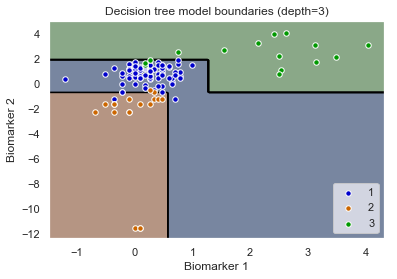

In [397]:
ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
ax.set_title("Decision tree model boundaries (depth=3)")
tree_3 = DecisionTreeClassifier(criterion="gini", max_depth=3).fit(X,y)
overlay_decision_boundary(ax, tree_3, colors=None, nx=200, ny=200, desaturate=.3)

The shapes of the decision boundaries are formed by lines perpendicular to one axis. The reason for this is that each branch in the decision tree is composed of a feature and single threshold value that maximally separates the classes for some subset of the data. Based on the plot above, it looks like the first branch may be composed of thresholding `Biomarker 2` at $\approx$ -0.5.

**4.3** Explain *in words* how the best fitted model diagnoses 'hypothyroidism' for a new patient. You can use the code below to examine the structure of the best decision tree.

*Entirely optional note:* You can also generate a visual representation using the `export_graphviz`. However, viewing the generated GraphViz file requires additional steps. One approach is to paste the generated graphviz file in the text box at http://www.webgraphviz.com/. Alternatively, you can run GraphViz on your own computer, but you may need to install some additional software. Refer to the [Decision Tree section of the sklearn user guide](http://scikit-learn.org/stable/modules/tree.html#classification) for more information.

In [344]:
# This code is adapted from
# http://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
def show_tree_structure(clf):
    tree = clf.tree_

    n_nodes = tree.node_count
    children_left = tree.children_left
    children_right = tree.children_right
    feature = tree.feature
    threshold = tree.threshold

    # The tree structure can be traversed to compute various properties such
    # as the depth of each node and whether or not it is a leaf.
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, -1)]  # seed is the root node id and its parent depth
    while len(stack) > 0:
        node_id, parent_depth = stack.pop()
        node_depth[node_id] = parent_depth + 1

        # If we have a test node
        if (children_left[node_id] != children_right[node_id]):
            stack.append((children_left[node_id], parent_depth + 1))
            stack.append((children_right[node_id], parent_depth + 1))
        else:
            is_leaves[node_id] = True

    print(f"The binary tree structure has {n_nodes} nodes:\n")
    
    for i in range(n_nodes):
        indent = node_depth[i] * "  "
        if is_leaves[i]:
            prediction = clf.classes_[np.argmax(tree.value[i])]
            print(f"{indent}node {i}: predict class {prediction}")
        else:
            print("{}node {}: if X[:, {}] <= {:.3f} then go to node {}, else go to node {}".format(
                indent, i, feature[i], threshold[i], children_left[i], children_right[i]))

In [364]:
# print formatted info for the tree nodes
show_tree_structure(tree_3)

The binary tree structure has 11 nodes:

node 0: if X[:, 1] <= -0.693 then go to node 1, else go to node 6
  node 1: if X[:, 0] <= 0.582 then go to node 2, else go to node 5
    node 2: if X[:, 0] <= -0.053 then go to node 3, else go to node 4
      node 3: predict class 2
      node 4: predict class 2
    node 5: predict class 1
  node 6: if X[:, 0] <= 1.270 then go to node 7, else go to node 10
    node 7: if X[:, 1] <= 1.879 then go to node 8, else go to node 9
      node 8: predict class 1
      node 9: predict class 3
    node 10: predict class 3


To diagnose hyperthyroidism, the tree first looks at `Biomarker 2` and then `Biomarker 1`. If `Biomarker 2` levels are below -0.693 and `Biomarker 1` levels are below 0.582, the tree classifies the patient as having hyperthyroidism. There is an additional branch in the tree below these nodes that has no effect on the outcome and could be removed from the model.

**Your answer here**


<div class='exercise'><b> Question 5 [18 pts]: k-NN and Model comparison </b> </div>

We have now seen six different ways of fitting a classification model: **linear logistic regression**, **logistic regression with polynomial terms**, **LDA**, **QDA**, **decision trees**, and in this problem we'll add **k-NN**. Which of these methods should we use in practice for this problem? To answer this question, we now compare and contrast these methods.

**5.1** Fit a k-NN classifier with uniform weighting to the training set. Use 5-fold CV to pick the best $k$.

*Hint: Use `KNeighborsClassifier` and `cross_val_score`.*


Best k-value = 4


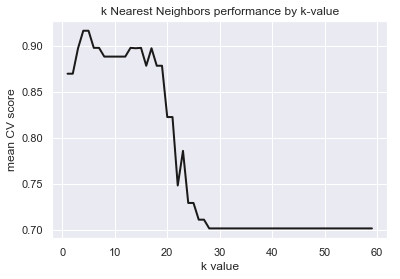

In [365]:
# define k values to test
k_vals = np.arange(1,60,1)
avg_score = np.empty(k_vals.shape, dtype=float)

# fit decision tree at each depth and record accuracy
for i, k in enumerate(k_vals):
    knn = KNeighborsClassifier(n_neighbors=k).fit(X,y)
    avg_score[i] = cross_val_score(knn, X, y, cv=5).mean()
    
plt.plot(k_vals, avg_score, c='k', lw=2)
ax = plt.gca()
ax.set_xlabel("k value")
ax.set_ylabel("mean CV score")
ax.set_title("k Nearest Neighbors performance by k-value");
print("\nBest k-value = %i" % k_vals[np.argmax(avg_score)])


**5.2** Plot the decision boundaries for each of the following models that you fit above. For models with hyperparameters, use the values you chose using cross-validation.
- Logistic Regression (linear)
- Logistic Regression (polynomial)
- Linear Discriminant Analysis 
- Quadratic Discriminant Analysis
- Decision Tree
- k-NN

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

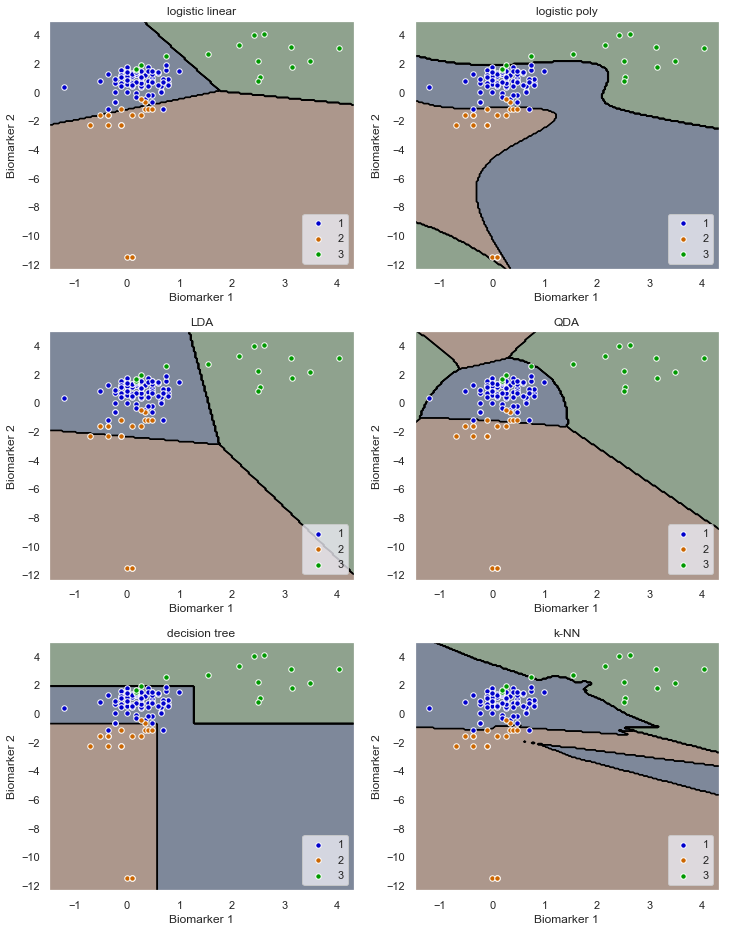

In [398]:
# initialize list of models
knn = KNeighborsClassifier(n_neighbors=4).fit(X,y)
models = [logit_base, logit_poly, lda, qda, tree_3, knn]
model_names = ["logistic linear","logistic poly","LDA","QDA","decision tree","k-NN"]

plt.figure(figsize=(12,16))
for i,model in enumerate(models):
    
    # intialize new subplot
    plt.subplot(3,2,i+1)
    ax = scatter_class(data_train.bio1.values, data_train.bio2.values, data_train.diagnosis.values)
    ax.set_title(model_names[i])
    overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.2)
    
plt.subplots_adjust(hspace=0.25)

Comment on the difference in the decision boundaries between the following pairs of models. Why does this difference make sense given how the model works?
- Linear logistic regression; LDA
- Quadratic logistic regression; QDA.
- k-NN and whichever other model has the most complex decision boundaries

**Comparing: Linear logistic and LDA**<br>

The boundary lines are linear in both cases, which we expect. As discussed in problem 3, the boundary line for LDA between class one and two looks a little too low because we essentially assume that all three classes share the same distribution shape (ie. covariance between features is the same for each class). The only free parameter it has no minimize the loss function (negative log likelihood) is the mean of those fitted distributions. Linear logistic regression is minimizing the negative log likelihood and has linear features, but makes no assumption about normally distributed predictors with equal the covariance.

**Comparing: Quadratic logistic and QDA**<br>

The key difference between the shapes of these two models is the assumption that our predictors are drawn from multivariate normal distribution in QDA. We can see the constraint of this assumption in the shapes of the contours of the boundary plot for QDA. We could not produce two multivariate normals with intersections of the shapes observed in the contours of the quadratic logistic model. The quadratic logistic model is fitting a quadratic line for each class vs the rest that minimizes the negative log likelihood.

**Comparing: kNN and Quadratic logistic**<br>

kNN produces highly irregular boundary lines, which makes sense as a non-parametric model. Although the quadratic logistic model is complex, we can see evidence of the polynomial coefficients in the smooth curves of the boundary lines.

**5.3** Describe how each model classifies an observation from the test set in one short sentence for each (assume that the model is already fit). For example, for the linear regression classifier you critiqued in hw5, you might write: "It classifies the observation as class 1 if the dot product of the feature vector with the the model coefficients (with constant added) exceeds 0.5."

- **Logistic Regression (One-vs-Rest)**<br>
    -Classifies the observation as class 1 if the probability of class 1 (calculated as negative log odds via the dot product of the feature vector and model coefficients and converted to odds then to probability) is higher than the probability of any other class<br><br>
- **Linear Discriminant** <br>
    -Classifies the observation as class 1 if the posterior probability of class 1 (calculated using bayes theorem as the p(observation|class) x p(class) / p(observation)) is higher than any other class, using the assumption that our observed feature values are normally within class 1 with some mean for each feature and some variance shared between all classes<br><br>
- **Quadratic Discriminant Analysis**<br>
    -Classifies the observation as class 1 if the posterior probability of class 1 (calculated using bayes theorem as the p(observation|class) x p(class) / p(observation)) is higher than any other class, using the assumption that our observed feature values are normally within class 1 with some mean and variance for each feature<br><br>
- **k-Nearest-Neighbors Classifier**<br>
    -Classifies the observation as class 1 if class 1 is the most common class in the k nearest neighbors of the data point<br><br>
- **Decision Tree**<br>
    -Classifies the observation as class 1 if it reaches a class 1 leaf node by being on "right" side of some number of threshold values for various features<br><br>

**5.4** Estimate the validation accuracy for each of the models. Summarize your results in a graph or table. (Note: for some models you have already run these computations; it's ok to redo them here if it makes your code cleaner.)

In [399]:
# define placeholder for accuracies
accuracy = np.empty(len(models),dtype=float)

# iterate over models and record mean cross-val accuracy
for i,model in enumerate(models):
        accuracy[i] = cross_val_score(model, X, y, cv=5).mean()
        
acc_df = pd.DataFrame(data=accuracy.reshape(1,-1), columns=model_names)
acc_df = acc_df.rename(index={0: "accuracy"})
acc_df

,logistic linear,logistic poly,LDA,QDA,decision tree,k-NN
accuracy,0.916883,0.897835,0.850649,0.887879,0.91645,0.91645


**5.5** Based on everything you've found in this question so far, which model would you expect to perform best on our test data? 

Now evaluate each fitted model's performance on the test set. Also, plot the same decision boundaries as above, but now showing the test set. How did the overall performance compare with your performance estimates above? Which model actually performed best? Why do you think this is the case?

I would expect either the decision tree or the logistic linear model to perform best. These should be less prone to overfitting than the logistic poly, QDA, or k-NN (with k=4). The LDA model is not likely to perform well on either data set because the assumption of equal covariance is not a good one for this data. If I have to pick one model, I'll choose decision tree. I like trees.


,logistic linear,logistic poly,LDA,QDA,decision tree,k-NN
accuracy,0.805195,0.878355,0.851082,0.850649,0.877922,0.8329


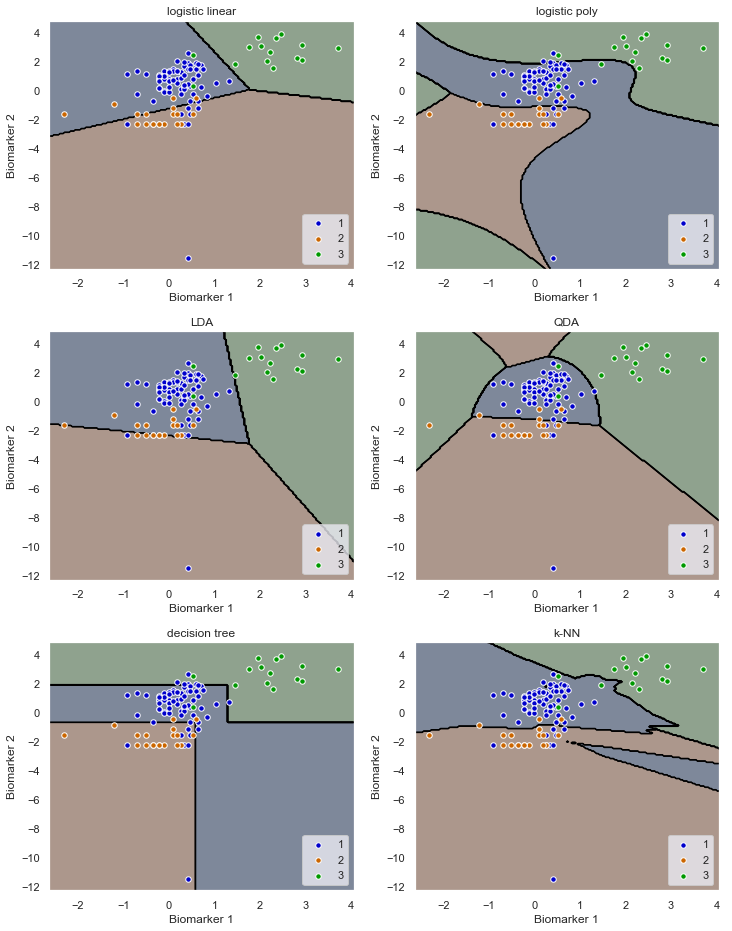

In [402]:
# define predictor/response
X_test = data_test[["bio1","bio2"]].values
y_test = data_test.diagnosis.values

# define placeholder for accuracies
accuracy = np.empty(len(models),dtype=float)

# iterate over models
plt.figure(figsize=(12,16))
for i,model in enumerate(models):
    
    # record mean cross-val accuracy
    accuracy[i] = cross_val_score(model, X_test, y_test, cv=5).mean()

    # intialize new subplot and plot results
    plt.subplot(3,2,i+1)
    ax = scatter_class(X_test[:,0],X_test[:,1],y_test)
    ax.set_title(model_names[i])
    overlay_decision_boundary(ax, model, colors=None, nx=200, ny=200, desaturate=.2)
    
plt.subplots_adjust(hspace=0.25)
        
acc_df = pd.DataFrame(data=accuracy.reshape(1,-1), columns=model_names)
acc_df = acc_df.rename(index={0: "accuracy"})
acc_df

The logistic quadratic model performs best, although the decision tree model is nearly as accurate. It looks most of the models were overfit (with the exception of LDA) to the training data. I'm surprised that the quadratic logistic model does as well as it does. It might do better because it actually models the data better, the best boundaries between these classes may not be straight lines. But our data set is also small enough and its margin over the decision tree model is small enough that it may just have randomly performed well on the test set.

**5.6**. Compare and contrast the six models based on each of the following criteria (a supporting table to summarize your  thoughts can be helpful):
  - Classification performance
  - Complexity of decision boundary
  - Memory storage
  - Interpretability
  
If you were a clinician who had to use the classifier to diagnose thyroid disorders in patients, which among the six methods would you be most comfortable in using? Justify your choice in terms of at least 3 different aspects.

**your answer here**


<div class='exercise'><b> Question 6: [2 pts] Including an 'abstain' option </b></div>
**Note this question is only worth 2 pts. **

One of the reasons a hospital might be hesitant to use your thyroid classification model is that a misdiagnosis by the model on a patient can sometimes prove to be very costly (e.g. if the patient were to file a law suit seeking a compensation for damages). One way to mitigate this concern is to allow the model to 'abstain' from making a prediction: whenever it is uncertain about the diagnosis for a patient. However, when the model abstains from making a prediction, the hospital will have to forward the patient to a thyroid specialist (i.e. an endocrinologist), which would incur additional cost.  How could one design a thyroid classification model with an abstain option, such that the cost to the hospital is minimized?

*Hint:* Think of ways to build on top of the logistic regression model and have it abstain on patients who are difficult to classify.



**6.1** More specifically, suppose the cost incurred by a hospital when a model mis-predicts on a patient is \$5000, and the cost incurred when the model abstains from making a prediction is \$1000. What is the average cost per patient for the OvR logistic regression model (without quadratic or interaction terms) from Question 2? Note that this needs to be evaluated on the patients in the test set. 

**6.2** Design a classification strategy (into the 3 groups plus the *abstain* group) that has as low cost as possible per patient (certainly lower cost per patient than the logistic regression model).   Give a justification for your approach.



**6.1**

**Your answer here**


In [42]:
# your code here


In [43]:
# your code here


**6.2**

**Your answer here**
